# A Comparison of KL Divergence VS Marginal Log Likelihood

In [1]:
from math import log, exp
from scipy.special import loggamma, digamma
import numpy as np
from matplotlib import pyplot as plt

The following calculates the probability density function of a Dirichlet distribution with the given `alphas` for the given `categorical_distribution`.

In [2]:
def dirichlet(alphas, categorical_distribution):
    A = sum(alphas)
    N = sum(categorical_distribution)
    constant = loggamma(A)
    terms = 0
    for a,x in zip(alphas,categorical_distribution):
        terms += loggamma(a) + log(x)*(a-1)
    return exp(terms - constant)

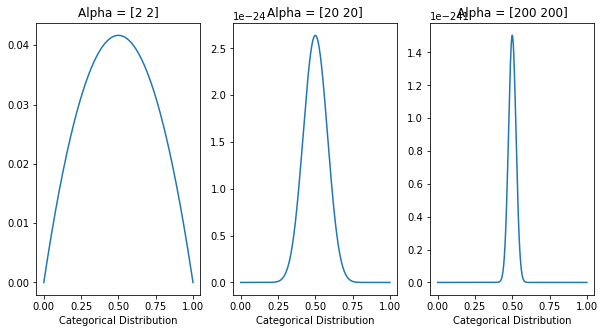

In [3]:
alphas = np.array([2, 2])
categoricals = np.concatenate([
    np.linspace(1e-7,1-1e-7, num = 1000).reshape([-1,1]),
    (1-np.linspace(1e-7,1-1e-7,num = 1000)).reshape([-1,1]),
    ], axis=1) 
fig, axs = plt.subplots(1,3)
for concentration,ax in zip([1,10,100], axs):
    y = [dirichlet(concentration*alphas, cat) for cat in categoricals] 
    ax.plot(categoricals[:,0], y)
    ax.set_title(f'Alpha = {concentration*alphas}')
    ax.set_xlabel("Categorical Distribution")

fig.set_size_inches(10,5)
fig.savefig(f"Dirichlet_pdfs.png", bbox_inches="tight")
plt.show()

The following calculates the marginal log likelihood of sampling the given `observations` term from the Dirichlet-multinomial distribution. 

We expect this to be high (it's a negative value) for sets of observations in distribution, and very low for out of distribution data. 

In [4]:
def dirichlet_mll(alphas, observations):
    A = sum(alphas)
    N = sum(observations)
    constant = loggamma(A) + loggamma(N+1) - loggamma(N + A)
    terms = 0
    for a,x in zip(alphas,observations):
        terms += loggamma(a + x) - loggamma(a) - loggamma(x+1)
    return constant + terms

This calculates the Kullback–Leibler divergence between the prior and posterior, `KL(Dir(X | Alphas), Dir(X | Alphas + Observation))`

We expect this to be low for in distribution observations, and very high for out of distribution data.   

In [5]:
def dirichlet_kl_div(alphas, observations):
    A = sum(alphas)
    N = sum(observations)
    constant = loggamma(A) - loggamma(A+N)
    terms = 0
    for a,x in zip(alphas,observations):
        terms += loggamma(a+x) - loggamma(a) - x*(digamma(a) - digamma(A))
    return constant + terms

For an intuition of how these work we can visualize some results. We'll do this in 2 buckets, so we'll have `alphas = (alpha_1, alpha_2)`. We'll then visualize the likelihood of seeing a given pair of observations in `[0,500] x [0,500]`. We'll again do so for different concentrations.

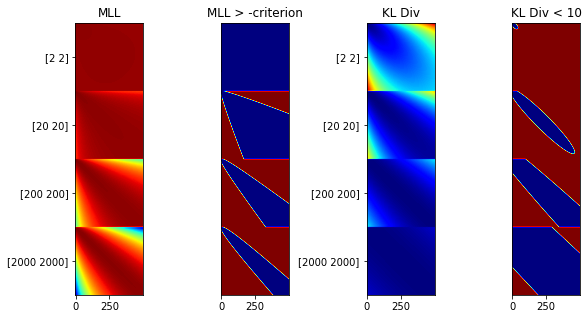

In [6]:
fig, ax = plt.subplots(1,4)
max_observations = 500
concentrations = [1, 10, 100, 1000]
criterion = 10
observations = np.mgrid[0:max_observations,0:max_observations]
y_ticks = [i*max_observations + max_observations/2 for i in range(len(concentrations))]
mll = []
for concentration in concentrations:
    mll_lambda = lambda x: dirichlet_mll(concentration*alphas, x)
    mll.append(mll_lambda(observations))
mll = np.concatenate(mll)
cbar = ax[0].imshow(mll, cmap="jet")
ax[0].set_title(f'MLL')
ax[0].set_yticks(y_ticks)
ax[0].set_yticklabels([f"{concentration*alphas}" for concentration in concentrations])

ax[1].imshow(mll < -criterion, cmap="jet")
ax[1].set_title(f'MLL > -criterion')
ax[1].set_yticks([])

kl_div = []
for concentration in concentrations:
    kl_div_lambda = lambda x: dirichlet_kl_div(concentration*alphas, x)
    kl_div.append(kl_div_lambda(observations))
kl_div = np.concatenate(kl_div)
cbar = ax[2].imshow(kl_div, cmap="jet")
ax[2].set_title(f'KL Div')
ax[2].set_yticks(y_ticks)
ax[2].set_yticklabels([f"{concentration*alphas}" for concentration in concentrations])

ax[3].imshow(kl_div > criterion, cmap="jet")
ax[3].set_title(f'KL Div < {criterion}')
ax[3].set_yticks([])

fig.set_size_inches(10,5)
fig.savefig(f"goodness_of_fit.png", bbox_inches="tight")
plt.show()


As the concentration increases, more potential observations become "likely" with the KL Divergence, but fewer potential observations become likely using the marginal log likelihood. Using the KL divergence metric we can even reject elements that are in distribution if the number ov observations is too high! 